# GR 3. - analiza MNIST database

#### Podstawy Reprezentacji i Analizy Danych
#### 1 lutego 2022

#### Partyk Chojnicki, Hubert Kalbarczyk

### 0. Wczytanie niezbędnych pakietów i zależności. Zdefiniowanie funkcji pomocniczych.

In [94]:
# pakiety i zależności:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import skimage.filters as sif

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import tree

In [108]:
# funkcje pomocnicze:

def display_shapes(train_data, test_data):
    print('Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: ')
    print('\tZbiór uczący: X={}, Y={}'.format(train_data.shape, trainY.shape))
    print('\tZbiór testowy: X={}, Y={}'.format(test_data.shape, testY.shape))

def basic_info():
    # liczba obiektów
    display_shapes(trainX, testX)
    # liczba klas
    classes_train = np.unique(trainY)
    classes_test = np.unique(testY)
    print('\nLiczba klas: ')
    print('\tZbiór uczący: {}'.format(classes_train.shape[0]))
    print('\tZbiór testowy: {}'.format(classes_test.shape[0]))
    # liczba obiektów w każdej klasie
    print('\nLiczba wystąpień każdej z klas (cyfr): ')
    ratio_list = []
    print('\tZbiór uczący\t\tZbiór testowy\t\tStosunek rekordów uczących do testowych')
    for i in range(0, 10):
        training_records_number_of_given_class = len([y for y in trainY if y == classes_train[i]])
        print('\tKlasa \'{}\' -> {}'.format(classes_train[i], training_records_number_of_given_class), end='')
        testing_records_number_of_given_class = len([y for y in testY if y == classes_test[i]])
        print('\tKlasa \'{}\' -> {}'.format(classes_test[i], testing_records_number_of_given_class), end='')
        ratio_list.append(training_records_number_of_given_class / testing_records_number_of_given_class)
        print('\t {}'.format(ratio_list[i]))
    print('\nOdchylenie standardowe stosunków: {}'.format(np.std(ratio_list)))
    print('Średni stosunek: {}'.format(np.mean(ratio_list)))
    print('Współczynnik zmienności: {} %'.format(round(np.std(ratio_list) * 100 / np.mean(ratio_list), 2)))
    # liczba danych brakujących
    print('\nLiczba brakujących danych -> ', end='')
    print(np.isnan(trainX).sum().sum() + np.isnan(trainY).sum() + np.isnan(testX).sum().sum() + np.isnan(trainY).sum().sum())

def display_examples(images, display_width=8, display_height=8, fontsize=36):
    fig, axs = plt.subplots(display_height, display_width)
    fig.set_size_inches(display_width * 2, display_height)
    plt.rc('figure', titlesize=fontsize)
    fig.suptitle('Przedstawienie przykładowych obiektów')
    for y in range(0, display_height):
        for x in range(0, display_width):
            axs[y, x].imshow(images[x + display_width * y], cmap=plt.get_cmap('gray'))
    plt.show()

def display_every_digit_variations(images, display_width=4, display_height=4, fontsize=18):
    for digit_to_find in range(0, 10):
        fig, axs = plt.subplots(display_height, display_width)
        fig.set_size_inches(display_width * 2, display_height)
        plt.rc('figure', titlesize=fontsize)
        fig.suptitle('Przedstawienie przykładowych rekordów z cyfrą {}'.format(digit_to_find))
        current_index = 0
        for y in range(0, display_height):
            for x in range(0, display_width):
                while trainY[current_index] != digit_to_find:
                    current_index += 1        
                axs[y, x].imshow(images[current_index], cmap=plt.get_cmap('gray'))
                current_index += 1    
    plt.show()

def flatten_images(images):
    return images.flatten().reshape(images.shape[0], images.shape[1] * images.shape[2])

def accuracy(model, train_data, test_data, classifier, display=True):
    model.fit(train_data, trainY)
    cm = confusion_matrix(testY, model.predict(test_data))
    if display:
        display_confusion_matrix(cm, classifier)
    return np.sum(np.diag(cm))/np.sum(cm)

def display_confusion_matrix(confusion_matrix_data, classifier):
    plt.figure(figsize=(10,5))
    axs = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='copper')
    axs.set_title('Macierz pomyłek dla {}'.format(classifier))
    axs.set_xlabel('Przypisane klasy')
    axs.set_ylabel('Wartości rzeczywiste')
    axs.set_xticklabels(range(0, 10))
    axs.set_yticklabels(range(0, 10))

def calculate_error(acc):
    return round((1 - acc) * 100, 2)

def change_resolution(images, resolution=14):
    return np.array([np.array(img.resize((resolution, resolution), Image.ANTIALIAS)) for img in [Image.fromarray(x) for x in images]])

def all_basic_classifiers_test(train_data, test_data, tree_max_depth=24):
    # klasyfikator k-najbliższych sąsiadów
    print('KLASYFIKATOR K-NAJBLIŻSZYCH SĄSIADÓW:')
    for k in range(1, 16, 2):
        model = KNeighborsClassifier(n_neighbors = k)
        acc = accuracy(model, train_data, test_data, 'klasyfikatora k-najbliższych sąsiadów -> k = {}'.format(k), False)
        print('\tk = {:2d}  \tDokładność = {}\t Błąd = {} %'.format(k, acc, calculate_error(acc)))
        
    # najbliższy prototyp
    print('\nKLASYFIKATOR NAJBLIŻSZEGO PROTOTYPU:')
    model = NearestCentroid()
    acc = accuracy(model, train_data, test_data, 'najbliższego prototypu (określanego przez średnią)', False)
    print('\tDokładność = {}\t Błąd = {} %'.format(acc, calculate_error(acc)))

    # klasyfikator Bayesa
    print('\nNAIWNY KLASYFIKATOR BAYESA:')
    model = GaussianNB()
    acc = accuracy(model, train_data, test_data, 'naiwnego klasyfikatora Bayesa', False)
    print('\tDokładność = {}\t Błąd = {} %'.format(acc, calculate_error(acc)))

    # drzewa decyzyjne
    print('\nDRZEWA DECYZYJNE:')
    for depth in range(1, tree_max_depth, 2):
        model = tree.DecisionTreeClassifier(max_depth=depth)
        acc = accuracy(model, train_data, test_data, 'drzewa decyzyjnego, max_depth = {}'.format(depth), False)
        print('\tmax_depth = {:2d}  \tDokładność = {}\t Błąd = {} %'.format(depth, acc, calculate_error(acc)))

def blur_images(images, sigma=3):
    return np.array([np.array(sif.gaussian(img, sigma, multichannel = False)) for img in images])

### 1. Wprowadzenie i wstępna analiza danych.

Celem projektu jest klasyfikacja cyfr pisanych odręcznie na podstawie bazy MNIST.  
Jest ona zbiorem obrazów przedstawiających właśnie odręcznie pisane cyfry (od 0 do 9), gdzie każda z cyfr wystepuje stosunkowo podobną liczbę razy.  
Obrazy są już po wstępnej obróbce - centryzacji, normalizacji wielkości na 28 x 28 pikseli oraz poddaniu antyaliasingowi (wygładzaniu krawędzi).  
Zbiór danych jest już bazowo podzielony na zbiór uczący oraz treningowy.

Format każdego obiektu: 
- X (obiekty - obrazy) -> dwuwymiarowy numpy array określający jasność poszczególnych pikseli w skali szarości
- Y (atrybuty decyzyjne - przyporządkowanie odpowiedniej cyfry) -> cyfra reprezentowana przez dany rekord

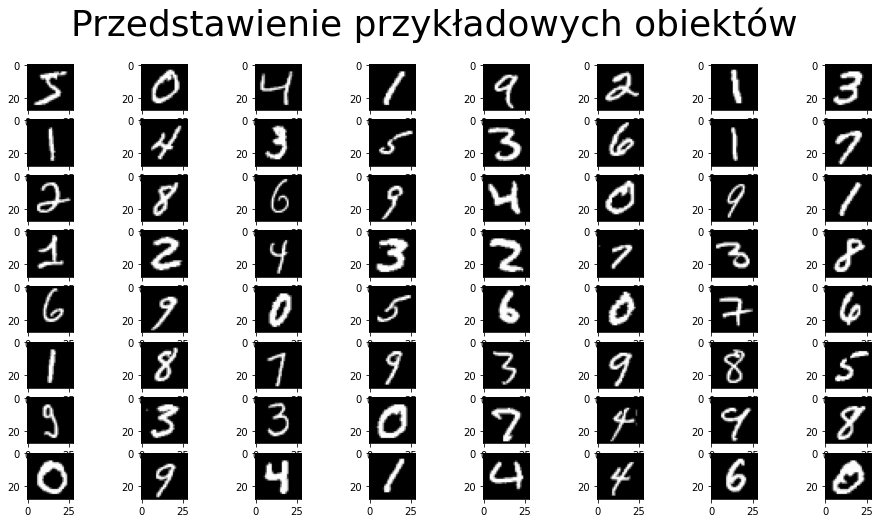

Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: 
	Zbiór uczący: X=(60000, 28, 28), Y=(60000,)
	Zbiór testowy: X=(10000, 28, 28), Y=(10000,)

Liczba klas: 
	Zbiór uczący: 10
	Zbiór testowy: 10

Liczba wystąpień każdej z klas (cyfr): 
	Zbiór uczący		Zbiór testowy		Stosunek rekordów uczących do testowych
	Klasa '0' -> 5923	Klasa '0' -> 980	 6.043877551020408
	Klasa '1' -> 6742	Klasa '1' -> 1135	 5.940088105726872
	Klasa '2' -> 5958	Klasa '2' -> 1032	 5.773255813953488
	Klasa '3' -> 6131	Klasa '3' -> 1010	 6.07029702970297
	Klasa '4' -> 5842	Klasa '4' -> 982	 5.94908350305499
	Klasa '5' -> 5421	Klasa '5' -> 892	 6.077354260089686
	Klasa '6' -> 5918	Klasa '6' -> 958	 6.177453027139875
	Klasa '7' -> 6265	Klasa '7' -> 1028	 6.094357976653696
	Klasa '8' -> 5851	Klasa '8' -> 974	 6.007186858316222
	Klasa '9' -> 5949	Klasa '9' -> 1009	 5.89593657086224

Odchylenie standardowe stosunków: 0.11028863479351828
Średni stosunek: 6.002889069652045
Współczynnik zmie

In [89]:
# wczytanie bazy danych MNIST
(trainX, trainY), (testX, testY) = mnist.load_data()

# wyświetlenie kilku pierwszych rekordów
display_examples(trainX)

# podstawowe własności zbioru danych
basic_info()

Analizując podstawowe własności zauważamy kompletność i spójność danych - nie wykryto nieprawidłowo zapisanych danych; liczbie obiektów zarówno przy zbiorze uczącym jak i testowym odpowiada tożsama im liczba atrybutów decyzyjnych; klas w obu zbiorach jest tyle samo i odpowiadają sobie nawzajem.  
Obserwujemy też stosunkowo zbliżoną liczbę obiektów przyporządkowaną do poszczególnych klas (choć zdecydowanie nie równą - skrajna różnica (dla 1 oraz 5) wynosi aż 1321).  
Co ciekawe, zbiór testowy nie jest podzielony dokładnie w takich samych proporcjach jak uczący (choć podział ten jest zbliżony) - współczynnik zmienności stosunków liczby rekordów uczących do testowych dla poszczególnych klas nie jest zerowy - wynosi 1.84 %. Nie jest to jednak wartość znacząco różnicująca udział poszczególnych klas w zbiorze uczącym i testowym - proporcje te są zbliżone.  
Do tworzenia modeli wykorzystamy zatem cały zbiór uczący, bez podziałów na podzbiory. Zakładamy bowiem prawidłowy, spójny i stosunkowo regularny podział zbiorów zawartych w bazie  MNIST.

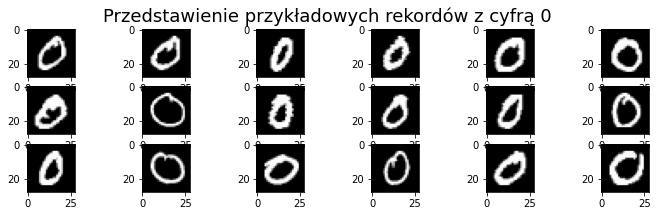

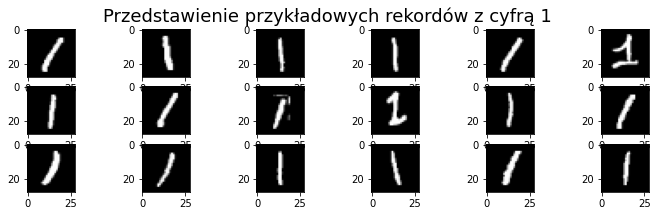

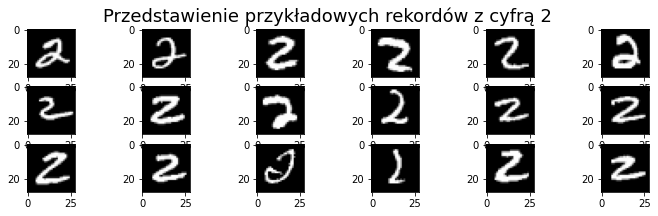

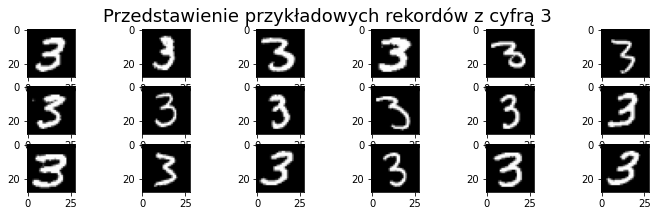

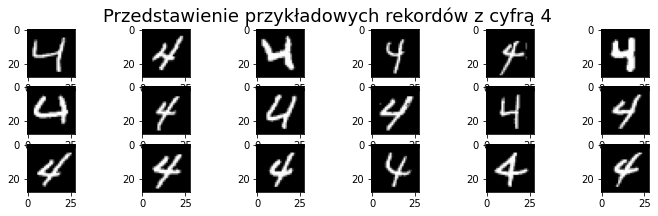

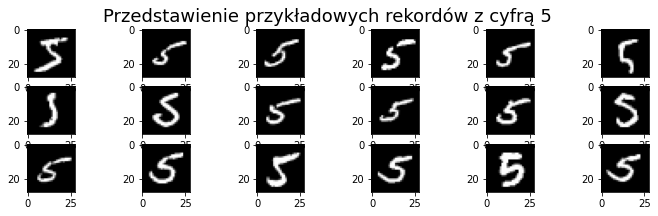

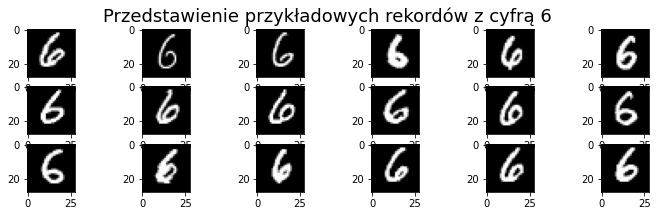

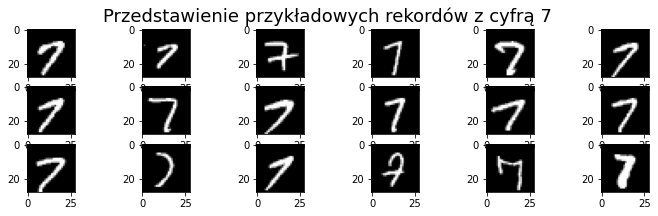

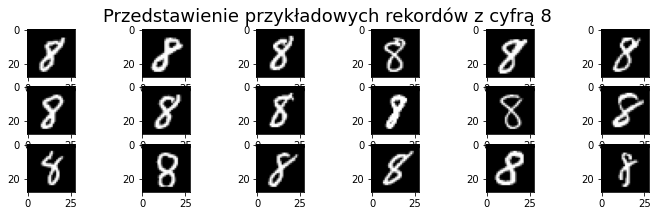

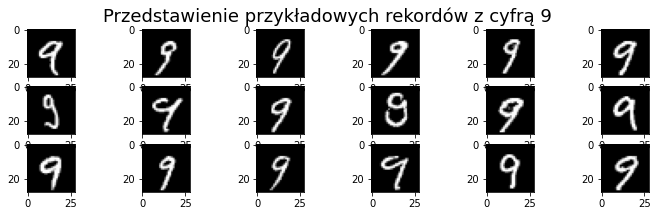

In [58]:
# wizualizacja powtarzalności / zróżnicowania rekordów tych samych klas
display_every_digit_variations(trainX, 6, 3)

Obserwujemy znaczące zróżnicowanie obiektów na przestrzeni jednej klasy. Dla przykładu cyfra 1 przez niektórych zpisywana jest jako podłużna "pałeczka" (w dodatku o różnych orientacjach), inni natomiast akcentują jej "głowę" oraz "podstawę". Podobnie 7 - w większości rekordów napisana jest za pomocą pojedynczej łamanej, jednak czasem, choć nieczęsto, zawiera też "przekreślenie". Stosunkowa nieliczność tego przypadku mogłaby skutkować na przykład w klasyfikowaniu tak napisanej cyfry 7 jako 4, która w przeważającej większości "przekreślenie" wyraźnie zawiera. Różnice obejmują także "domykanie" cyfr - czasem pętla, która powinna być zamknięta, tworząc "dziurę", pozostaje otwarta, pozostawiając cyfrę bez wyraźnej, właściwej jej dziury (0, 6, 8, 9). Widocznych jest także wiele innych subtylnych różnic. Czasem nawet cyfry zapisane są niemal nieczytelnie nawet dla czytającego je człowieka - niech przykładem będzie jedna z cyfr 2, będąca jedynie nieco dziwną pętelką. Analizowane cyfry odręczne różnią się więc w znaczącym stopniu od ustandaryzowanego pisma komputerowego, z którego w sposób bardziej określony można by wywnioskować pewne cechy opisujące.  

Wynika stąd, że niezwykle trudno byłoby określić i właściwie dopasować cechy obiektów, które mogłyby posłużyć do klasyfikacji. Orientacja potrafi być zróżnicowana na przestrzeni jednej klasy, podobnie liczba Eulera. Niektóre obiekty są bardziej rozwlekłe, inne bardziej skondensowane. Występują nawet zdecydowanie różne sposoby pisania tej samej cyfry.  

Biorąc powyższe pod uwagę, jako atrybutów opisujących użyjemy każdego piksela oddzielnie. Zatem będzie ich 28 * 28 = 784. Każdy z nich zaś określa jasność danego piksela w skali szarości <0, 255>.  

Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: 
	Zbiór uczący: X=(60000, 784), Y=(60000,)
	Zbiór testowy: X=(10000, 784), Y=(10000,)


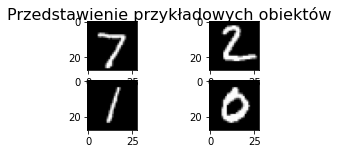

[7 2 1 ... 4 5 6]


In [90]:
# "spłaszczenie" macierzy pikseli każdego z obrazów do jednowymiarowych wektorów atrybutów opisowych
trainX_flat = flatten_images(trainX)
testX_flat  = flatten_images(testX)

# upewnimy się jeszcze pobieżnie, czy dane zostały spłaszczone prawidłowo:
display_shapes(trainX_flat, testX_flat)
# pierwsze obiekty testowe
display_examples(testX, 2, 2, 16)
# skorzystamy w tym celu z przykładowego klasyfikatora - najbliższego sąsiada
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(trainX_flat, trainY)
print(model.predict(testX_flat))

Jak widać powyżej, pierwsze trzy cyfry klasyfikowane są prawidłowo. Zakładamy zatem, że spłaszczanie przebiegło prawidłowo.

### 2. Klasyfikatory z zajęć - wybór najlepszego:

Pod uwagę weźmiemy następujące klasyfikatory:  
a) Metoda k-najbliższych sąsiadów (w różnych wariantach)  
b) Metoda najbliższego prototypu  
c) Naiwny klasyfikatory Bayesa  
d) Drzewa decyzyjne (w różnych wariantach)

UWAGA! Wszelkie wnioski prowadzone są przy założeniu przyjęcia za atrybuty opisujące każdego piksela z osobna. Prawdopodobnym jest, że przy innym ich doborze wnioski znacząco by się różniły.  
Warte wspomnienia również jest, że przy klasyfikatorach minimalnoodległościowych badaliśmy jedynie przypadek wykorzystania metryki euklidesowej (miejska oraz Czybyszewa miały nieporównywalnie dłuższy czas obliczeń).

#### a) Klasyfikator k-najbliższych sąsiadów

	k =  1  	Dokładność = 0.9691	 Błąd = 3.09 %
	k =  3  	Dokładność = 0.9705	 Błąd = 2.95 %
	k =  5  	Dokładność = 0.9688	 Błąd = 3.12 %
	k =  7  	Dokładność = 0.9694	 Błąd = 3.06 %
	k =  9  	Dokładność = 0.9659	 Błąd = 3.41 %
	k = 11  	Dokładność = 0.9668	 Błąd = 3.32 %
	k = 13  	Dokładność = 0.9653	 Błąd = 3.47 %
	k = 15  	Dokładność = 0.9633	 Błąd = 3.67 %


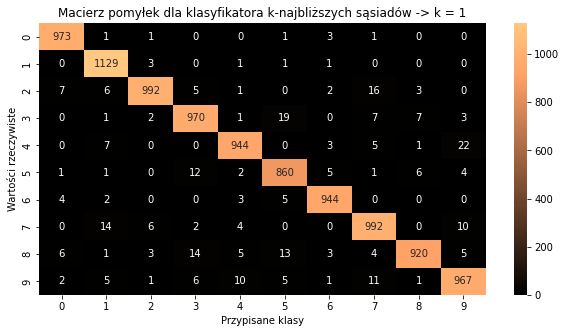

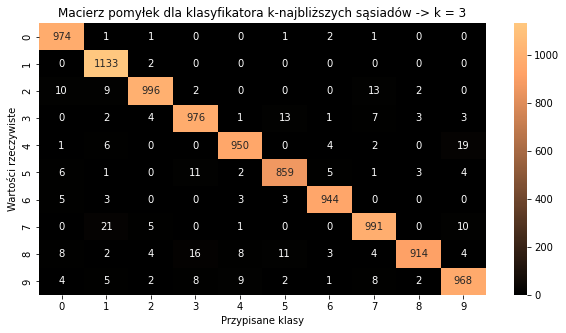

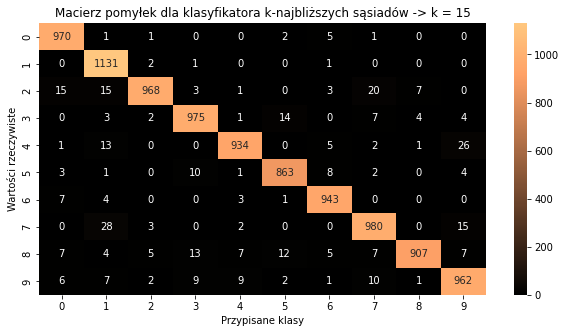

In [27]:
for k in range(1, 16, 2):
    model = KNeighborsClassifier(n_neighbors = k)
    acc = accuracy(model, trainX_flat, testX_flat, 'klasyfikatora k-najbliższych sąsiadów -> k = {}'.format(k), k in [1, 3, 15])
    print('\tk = {:2d}  \tDokładność = {}\t Błąd = {} %'.format(k, acc, calculate_error(acc)))

Dokładność klasyfikatora k-najbliższych sąsiadów dla każdej wartości k okazała się być znacząca. W najlepszym przypadku (dla k = 3) błędne dopasowania stanowią jedynie 2.95%, w najgorszym zaś (dla k = 15) stosunkowo niedużo więcej, bo 3.67 %.  
Jako że wskazany klasyfikator nie przechodzi fazy uczenia, czas oczekiwania na wyniki był stosunkowo długi (w porównaniu do pozostałych klasyfikatorów), jednak jest to rekompensowanane dużą dokładnością.  
Na macierzach pomyłek obserwujemy, rekordy których klas zostały niewłaściwie przypisane. Pomimo innych liczebności, dla różnych k tendencje są raczej podobne. Pojedyncze przyprzypadki okazjonalnie się zdarzają, niewykluczone jest bowiem istnienie w danych zbiorach wartości nieczytelnych tak dla komputera jak i dla człowieka (przykładowo jedna z dwójek obserwowanych na początku). Według modelu największym podobieństwem odznaczały się: 2 -> 0, 1, 7; 3 -> 5; 4 -> 9, 5 -> 3; 7 -> 1, 9; 8 -> 3, 5. Co ciekawe, jedyną parą dwustronnie do siebie podobną są cyfry 5 i 3. Najbardziej niepodobne do innych okazały się 0 i 1, później 6. Można zatem z powodzeniem sprawdzać pisemne prace zaliczeniowe z techniki cyfrowej za pomocą przedstawionego modelu (choć sam model to chyba jednak wciąż trochę zbyt mało).

#### b) Klasyfikator najbliższego prototypu

Dokładność = 0.8203	 Błąd = 17.97 %


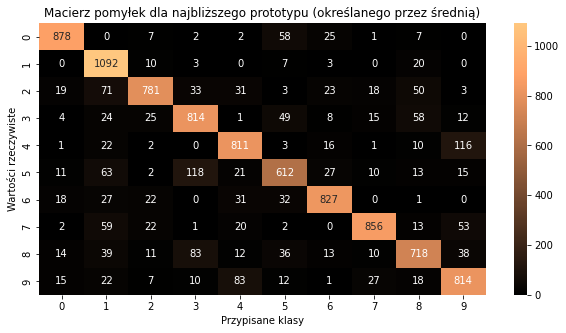

In [55]:
model = NearestCentroid()
acc = accuracy(model, trainX_flat, testX_flat, 'najbliższego prototypu (określanego przez średnią)')
print('Dokładność = {}\t Błąd = {} %'.format(acc, calculate_error(acc)))

Klasyfikator najbliższego prototypu okazał się naturalnie nieporównywalnie szybszy niż k-najbliższych sąsiadów - przez wzgląd na proces uczenia.
Jednak wyniki klasyfikacji są znacząco mniej dokładne - błąd jest na poziomie prawie 18%. Jest to wynik na ogół niedopuszczalny, jednak wciąż imponujący jest taki poziom dokładności przy tej szybkości działania. Również z natury sama metoda uśrednienia każdego rekordu danej klasy do jednej ustalonej wartości źle służyć może generalizacji przypadków nieco bardziej odchylonych od normy - możliwe że mniejsza liczba danych uczących poprawiłaby wynik tego klasyfikatora.  
Z macierzy pomyłek wyczytujemy, że najlepiej dopasowano cyfrę 1. Przypadki złych przypisań natomiast są tu dużo częstsze niż poprzednio. 5 zostało określone jako 3 oraz 4 jako 9 więcej niż stukrotnie! Ponownie, raczej niewiele jest par cyfr mylonych w dużym stopniu naprzemiennie. Są to 2 i 8, 5 i 3, 0 i 6.

#### c) Naiwny klasyfikator Bayesa

Dokładność = 0.5558	 Błąd = 44.42 %


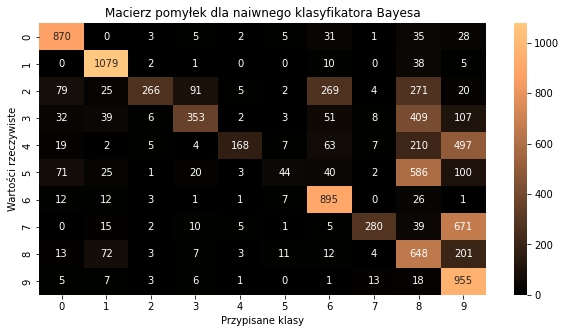

In [29]:
model = GaussianNB()
acc = accuracy(model, trainX_flat, testX_flat, 'naiwnego klasyfikatora Bayesa')
print('Dokładność = {}\t Błąd = {} %'.format(acc, calculate_error(acc)))

Naiwny klasyfikator Bayesa odznaczył się dokładnością zaledwie około 55.6 %. Do przedstawionego zadania raczej się więc nie nadaje, jednak wciąż daje lepsze wyniki niż rzut kostką dziesięciościenną. Słabość utworzonego modelu spowodowana jest najpewniej tytułową "naiwnością" klasyfikatora. Oznacza ona, że z założenia atrybuty opisujące powinny być od siebie w znacznym stopniu niezależne. Jednak przy analizie obrazu założenie to jest prawie na pewno niespełniane - jeżeli któryś punkt jest bowiem jasny (zamalowany), to wtedy prawdopodobnym jest, że punkt sąsiedni też taki będzie. Również przy określaniu wzorca (klasyfikacji) naszym celem jest poszukiwanie takich właśnie zależności. Biorąc to pod uwagę, możliwe że model poradził sobie tutaj nawet lepiej niż powinien.  
Przeważająca liczba złych przypisań to wskazywanie na 8 lub 9. Co ciekawe, cyfry 1 i 9 zostały niewłaściwie przypisane w stosunkowo niewielu przypadkach, podobnie cyfra 6, a następnie 0. Podobną tendencją niepodobieństwa wykazał się klasyfikator k-najbliższych sąsiadów. Jednak cyfry 2, 3, 4, 5 i 7 już tyle szczęścia nie miały - częściej były klasyfikowane jako coś innego niż one same.  
Założenie wyższości tego modelu nad kostką należy więc zmodyfikować - rozpoznaje on bowiem jedynie niektóre cyfry, pozostałe niemal definitywnie przypisując w niewłaściwy sposób.

#### d) Drzewa decyzyjne

	max_depth =  1  	Dokładność = 0.1994	 Błąd = 80.06 %
	max_depth =  3  	Dokładność = 0.4953	 Błąd = 50.47 %
	max_depth =  5  	Dokładność = 0.6747	 Błąd = 32.53 %
	max_depth =  7  	Dokładność = 0.7853	 Błąd = 21.47 %
	max_depth =  9  	Dokładność = 0.8501	 Błąd = 14.99 %
	max_depth = 11  	Dokładność = 0.876	 Błąd = 12.4 %
	max_depth = 13  	Dokładność = 0.8787	 Błąd = 12.13 %
	max_depth = 15  	Dokładność = 0.8823	 Błąd = 11.77 %
	max_depth = 17  	Dokładność = 0.8832	 Błąd = 11.68 %
	max_depth = 19  	Dokładność = 0.8801	 Błąd = 11.99 %
	max_depth = 21  	Dokładność = 0.8782	 Błąd = 12.18 %
	max_depth = 23  	Dokładność = 0.8769	 Błąd = 12.31 %
	max_depth = 25  	Dokładność = 0.8793	 Błąd = 12.07 %
	max_depth = 27  	Dokładność = 0.8764	 Błąd = 12.36 %
	max_depth = 29  	Dokładność = 0.8804	 Błąd = 11.96 %


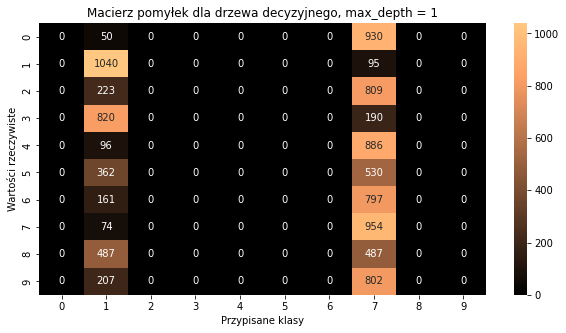

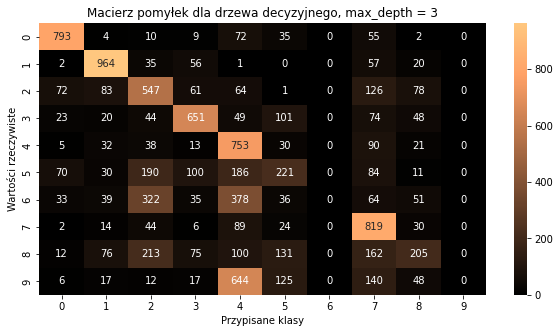

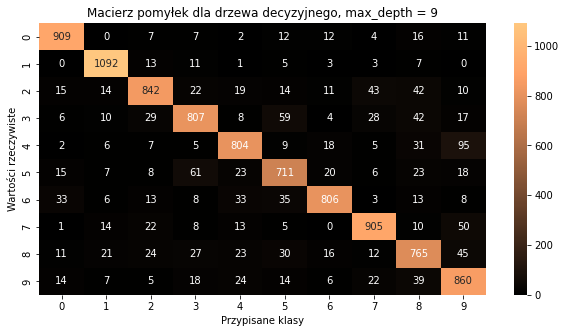

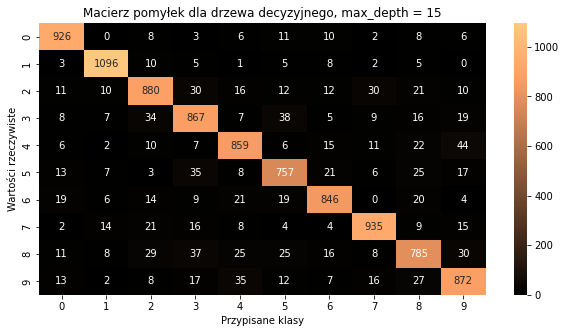

In [40]:
for depth in range(1, 31, 2):
    model = tree.DecisionTreeClassifier(max_depth=depth)
    acc = accuracy(model, trainX_flat, testX_flat, 'drzewa decyzyjnego, max_depth = {}'.format(depth), depth in [1, 3, 9, 15])
    print('\tmax_depth = {:2d}  \tDokładność = {}\t Błąd = {} %'.format(depth, acc, calculate_error(acc)))

Przy pojedynczej decyzji, właściwy wynik osiągamy w około 20% przypadków - to wynik bardzo analogiczny do rzutu dziesięciościenną kostką! Choć może jednak niekoniecznie, bo macierz pomyłek wyraźnie wskazuje, że model nauczył się jedynie w miarę sprawnie wskazywać 1 oraz 7 (jeżeli dostanie je na wejściu). Jednak w pozostałych przypadkach też wskaże te cyfry, innych zaś nigdy! Jednak oczywiście przy szerszym zakresie decyzyjnym dokładność modelu rośnie, osiągając szczytową wartość około 88.32 % przy maksymalnej głębokości wynoszącej 17 (możliwe że udałoby się znaleźć inną, jeżeli sprawdzalibyśmy też parzyste głębokości, jednak różnica byłaby definitywnie nieznaczna). W ogólności, przy głębokości większej / równej 11 dokładność kolejnych iteracji się stabilizuje, oscylując pomiędzy 87.5 % a 88.5 %. Dostrzec można jednak pewną, wspomnianą wcześniej wartość maksymalną. Dla kolejnych iteracji względem niej obserwwujemy delikatną utratę jakości modelów, prawdopodobnie przez zjawisko przeuczenia i utraty zdolności generalizacyjnych. Co ciekawe, zjawisko to nie postępuje stopniowo / monotonicznie, zaskakując czasem wynikami klasyfikacji lepszymi od poprzednich. Również warte wspomnienia jest, że kolejne uruchomienia programu generowały nieco inne wyniki.  
Obserwujemy na macierzy pomyłek zadziwiające w stosunku do pozostałych klasyfikatorów zjawisko - gdzie odpowiadające sobie przypisania podobnych cyfr były rzadkością, tutaj są niezwykle powszechne. Wynika to najprawdopodobniej ze struktury drzewa decyzyjnego. Po wejściu w ostatni węzeł przed wybraniem jednego z dwóch liści, obiekt zostanie sklasyfikowany bowiem jako jeden albo drugi, a nie żaden inny.

### 3. Preprocessing obrazów wejściowych

a) zmniejszenie rozdzielczości  
b) rozmywanie obrazu

#### a) Zmniejszenie rozdzielczości

Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: 
	Zbiór uczący: X=(60000, 14, 14), Y=(60000,)
	Zbiór testowy: X=(10000, 14, 14), Y=(10000,)


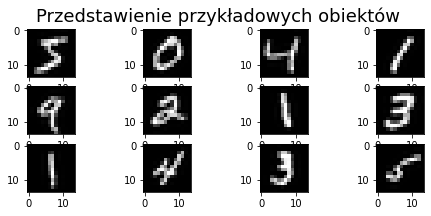

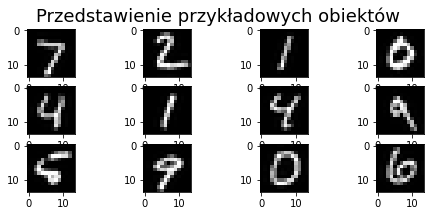

Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: 
	Zbiór uczący: X=(60000, 196), Y=(60000,)
	Zbiór testowy: X=(10000, 196), Y=(10000,)


In [91]:
# dwukrotne pomniejszenie - 14x14
trainX_low_res = change_resolution(trainX)
testX_low_res = change_resolution(testX)

display_shapes(trainX_low_res, testX_low_res)

display_examples(trainX_low_res, 4, 3, 18)
display_examples(testX_low_res, 4, 3, 18)

trainX_low_res = flatten_images(trainX_low_res)
testX_low_res = flatten_images(testX_low_res)

display_shapes(trainX_low_res, testX_low_res)

In [93]:
all_basic_classifiers_test(trainX_low_res, testX_low_res)

KLASYFIKATOR K-NAJBLIŻSZYCH SĄSIADÓW:
	k =  1  	Dokładność = 0.9746	 Błąd = 2.54 %
	k =  3  	Dokładność = 0.9753	 Błąd = 2.47 %
	k =  5  	Dokładność = 0.9756	 Błąd = 2.44 %
	k =  7  	Dokładność = 0.9757	 Błąd = 2.43 %
	k =  9  	Dokładność = 0.9758	 Błąd = 2.42 %
	k = 11  	Dokładność = 0.9741	 Błąd = 2.59 %
	k = 13  	Dokładność = 0.9724	 Błąd = 2.76 %
	k = 15  	Dokładność = 0.9714	 Błąd = 2.86 %

KLASYFIKATOR NAJBLIŻSZEGO PROTOTYPU:
	Dokładność = 0.8179	 Błąd = 18.21 %

NAIWNY KLASYFIKATOR BAYESA:
	Dokładność = 0.6606	 Błąd = 33.94 %

DRZEWA DECYZYJNE:
	max_depth =  1  	Dokładność = 0.1885	 Błąd = 81.15 %
	max_depth =  3  	Dokładność = 0.5007	 Błąd = 49.93 %
	max_depth =  5  	Dokładność = 0.6682	 Błąd = 33.18 %
	max_depth =  7  	Dokładność = 0.7797	 Błąd = 22.03 %
	max_depth =  9  	Dokładność = 0.8404	 Błąd = 15.96 %
	max_depth = 11  	Dokładność = 0.8741	 Błąd = 12.59 %
	max_depth = 13  	Dokładność = 0.887	 Błąd = 11.3 %
	max_depth = 15  	Dokładność = 0.8854	 Błąd = 11.46 %
	max_depth =

Co ciekawe, po dwukrotnym zmniejszeniu rozdzielczości wyniki klasyfikacji stały się dokładniejsze!  
Dla metody k-najbliższych sąsiadów poprawa wynosi około 0.5 pkt. %.  
Klasyfikator Bayesa z błędu 44.5% poprawił się do 34%. Może być to spowodowane dodaniem większego zakresu szarości.  
Drzewa decyzyjne poprawiły się podobnie jak klasyfikator k-najbliższych sąsiadów - o około 0.5 pkt. %.

Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: 
	Zbiór uczący: X=(60000, 7, 7), Y=(60000,)
	Zbiór testowy: X=(10000, 7, 7), Y=(10000,)


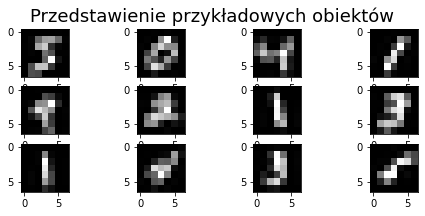

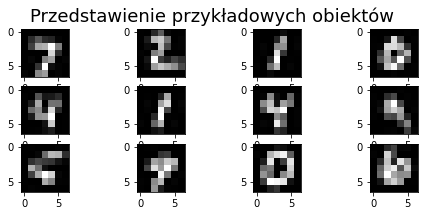

Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: 
	Zbiór uczący: X=(60000, 49), Y=(60000,)
	Zbiór testowy: X=(10000, 49), Y=(10000,)


In [95]:
# czterokrotne pomniejszenie - 7x7
trainX_low_res = change_resolution(trainX, 7)
testX_low_res = change_resolution(testX, 7)

display_shapes(trainX_low_res, testX_low_res)

display_examples(trainX_low_res, 4, 3, 18)
display_examples(testX_low_res, 4, 3, 18)

trainX_low_res = flatten_images(trainX_low_res)
testX_low_res = flatten_images(testX_low_res)

display_shapes(trainX_low_res, testX_low_res)

In [98]:
all_basic_classifiers_test(trainX_low_res, testX_low_res)

KLASYFIKATOR K-NAJBLIŻSZYCH SĄSIADÓW:
	k =  1  	Dokładność = 0.9548	 Błąd = 4.52 %
	k =  3  	Dokładność = 0.9579	 Błąd = 4.21 %
	k =  5  	Dokładność = 0.9599	 Błąd = 4.01 %
	k =  7  	Dokładność = 0.9601	 Błąd = 3.99 %
	k =  9  	Dokładność = 0.9588	 Błąd = 4.12 %
	k = 11  	Dokładność = 0.9575	 Błąd = 4.25 %
	k = 13  	Dokładność = 0.9568	 Błąd = 4.32 %
	k = 15  	Dokładność = 0.9575	 Błąd = 4.25 %

KLASYFIKATOR NAJBLIŻSZEGO PROTOTYPU:
	Dokładność = 0.7951	 Błąd = 20.49 %

NAIWNY KLASYFIKATOR BAYESA:
	Dokładność = 0.6833	 Błąd = 31.67 %

DRZEWA DECYZYJNE:
	max_depth =  1  	Dokładność = 0.1968	 Błąd = 80.32 %
	max_depth =  3  	Dokładność = 0.4071	 Błąd = 59.29 %
	max_depth =  5  	Dokładność = 0.5871	 Błąd = 41.29 %
	max_depth =  7  	Dokładność = 0.7464	 Błąd = 25.36 %
	max_depth =  9  	Dokładność = 0.8154	 Błąd = 18.46 %
	max_depth = 11  	Dokładność = 0.8629	 Błąd = 13.71 %
	max_depth = 13  	Dokładność = 0.8829	 Błąd = 11.71 %
	max_depth = 15  	Dokładność = 0.8884	 Błąd = 11.16 %
	max_depth

Kolejne dwukrotne pomniejszenie wyraźnie pogorszyło dokładność dla metody k-najbliższych sąsiadów (dwukrotnie).
Dla drzew decyzyjnych natomiast nastąpiła marginalna poprawa.
Klasyfikator Bayesa również dał w tym wypadku nieco lepsze rezultaty niż poprzednio.

Zmniejszenie rozdzielczości powoduje też wyraźne przyspieszenie procesu klasyfikacji (tak było też w poprzednim przypadku, jednak nieco mniej wyraźnie).

Wskazuje to na fakt zachowania pewnych własności przez obrazy wejściowe nawet po znacznej kompresji - odpowiednio wyuczona maszyna wciąż jest w stanie odpowiednio przyporządkować klasy do obiektów, nawet jeżeli dla człowieka zaczyna sprawiać to pewną trudność.

#### b) Rozmywanie obrazu

C:\Users\pchoj\AppData\Local\Temp\ipykernel_16296\3844768115.py:113: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return np.array([np.array(sif.gaussian(img, sigma, multichannel = False)) for img in images])


Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: 
	Zbiór uczący: X=(60000, 28, 28), Y=(60000,)
	Zbiór testowy: X=(10000, 28, 28), Y=(10000,)


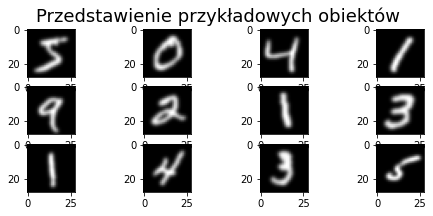

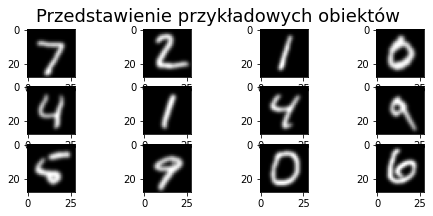

Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: 
	Zbiór uczący: X=(60000, 784), Y=(60000,)
	Zbiór testowy: X=(10000, 784), Y=(10000,)


In [102]:
# filtr Gaussa, sigma = 1
trainX_blurred = blur_images(trainX, sigma=1)
testX_blurred = blur_images(testX, sigma=1)

display_examples(trainX_blurred, 4, 3, 18)
display_examples(testX_blurred, 4, 3, 18)

trainX_blurred = flatten_images(trainX_blurred)
testX_blurred = flatten_images(testX_blurred)

In [104]:
all_basic_classifiers_test(trainX_blurred, testX_blurred)

KLASYFIKATOR K-NAJBLIŻSZYCH SĄSIADÓW:
	k =  1  	Dokładność = 0.9121	 Błąd = 8.79 %
	k =  3  	Dokładność = 0.9182	 Błąd = 8.18 %
	k =  5  	Dokładność = 0.9214	 Błąd = 7.86 %
	k =  7  	Dokładność = 0.9205	 Błąd = 7.95 %
	k =  9  	Dokładność = 0.9211	 Błąd = 7.89 %
	k = 11  	Dokładność = 0.9208	 Błąd = 7.92 %
	k = 13  	Dokładność = 0.9196	 Błąd = 8.04 %
	k = 15  	Dokładność = 0.9207	 Błąd = 7.93 %

KLASYFIKATOR NAJBLIŻSZEGO PROTOTYPU:
	Dokładność = 0.6286	 Błąd = 37.14 %

NAIWNY KLASYFIKATOR BAYESA:
	Dokładność = 0.6439	 Błąd = 35.61 %

DRZEWA DECYZYJNE:
	max_depth =  1  	Dokładność = 0.2006	 Błąd = 79.94 %
	max_depth =  3  	Dokładność = 0.4176	 Błąd = 58.24 %
	max_depth =  5  	Dokładność = 0.6243	 Błąd = 37.57 %
	max_depth =  7  	Dokładność = 0.7035	 Błąd = 29.65 %
	max_depth =  9  	Dokładność = 0.7768	 Błąd = 22.32 %
	max_depth = 11  	Dokładność = 0.8081	 Błąd = 19.19 %
	max_depth = 13  	Dokładność = 0.8283	 Błąd = 17.17 %
	max_depth = 15  	Dokładność = 0.8391	 Błąd = 16.09 %
	max_depth

Po rozmyciu filtrem Gaussa z sigmą = 1, dokładność poszczególnych rozwiązań znacząco uległa pogorszeniu. Przykładowo dla klasyfikatora k-najbliższych sąsiadów nastąpiło około 2.5 krotnie pogorszenie dokładności. Klasyfikator najbliższego prototypu pogorszył się około dwukrotnie. Są to bardzo znaczące różnice. Naiwny klasyfikator Bayesa natomiast jako jedyny uległ niespodziewanej, choć nie aż tak dużej, poprawie. Drzewa decyzyjne przy odpowiedniej głębokości zaczęły dawać dosyć przyzwoite odpowiedzi, jednak wciąż są one gorsze niż bez preprocessingu. Dotatkowo, proces ten trwa znacznie tu dłużej niż w przypadku niezmienionych danych wejściowych.

C:\Users\pchoj\AppData\Local\Temp\ipykernel_16296\3844768115.py:113: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return np.array([np.array(sif.gaussian(img, sigma, multichannel = False)) for img in images])


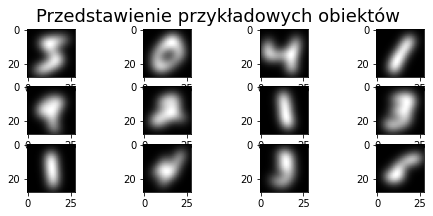

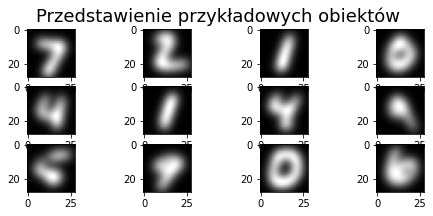

In [103]:
# filtr Gaussa, sigma = 3
trainX_blurred = blur_images(trainX, sigma=3)
testX_blurred = blur_images(testX, sigma=3)

display_examples(trainX_blurred, 4, 3, 18)
display_examples(testX_blurred, 4, 3, 18)

trainX_blurred = flatten_images(trainX_blurred)
testX_blurred = flatten_images(testX_blurred)

In [107]:
all_basic_classifiers_test(trainX_blurred, testX_blurred, tree_max_depth=13)

KLASYFIKATOR K-NAJBLIŻSZYCH SĄSIADÓW:
	k =  1  	Dokładność = 0.9121	 Błąd = 8.79 %
	k =  3  	Dokładność = 0.9182	 Błąd = 8.18 %
	k =  5  	Dokładność = 0.9214	 Błąd = 7.86 %
	k =  7  	Dokładność = 0.9205	 Błąd = 7.95 %
	k =  9  	Dokładność = 0.9211	 Błąd = 7.89 %
	k = 11  	Dokładność = 0.9208	 Błąd = 7.92 %
	k = 13  	Dokładność = 0.9196	 Błąd = 8.04 %
	k = 15  	Dokładność = 0.9207	 Błąd = 7.93 %

KLASYFIKATOR NAJBLIŻSZEGO PROTOTYPU:
	Dokładność = 0.6286	 Błąd = 37.14 %

NAIWNY KLASYFIKATOR BAYESA:
	Dokładność = 0.6439	 Błąd = 35.61 %

DRZEWA DECYZYJNE:
	max_depth =  1  	Dokładność = 0.2006	 Błąd = 79.94 %
	max_depth =  3  	Dokładność = 0.4176	 Błąd = 58.24 %
	max_depth =  5  	Dokładność = 0.6243	 Błąd = 37.57 %
	max_depth =  7  	Dokładność = 0.7038	 Błąd = 29.62 %
	max_depth =  9  	Dokładność = 0.7766	 Błąd = 22.34 %
	max_depth = 11  	Dokładność = 0.8088	 Błąd = 19.12 %
	max_depth = 13  	Dokładność = 0.8303	 Błąd = 16.97 %
	max_depth = 15  	Dokładność = 0.8371	 Błąd = 16.29 %
	max_depth

Zwiększenie stopnia rozmycia nie zmieniło w znaczący sposób rezultatów klasyfikacji.

Z powyżych prób rozmycia obrazów wyjściowych wynika, że w przypadku naszych danych i metod klasyfikacji pozbawione jest to sensu, dając tylko gorsze wyniki.

### 4. Próba użycia sieci neuronowych.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
from skimage import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import skimage.morphology as simo
from skimage import exposure
import skimage.filters as sif

def normalize_img(image, label):
    """Zamieniamy pixele z watrości 0 - 255 na wartości 0.0 - 1.0"""
    return tf.cast(image, tf.float32) / 255., label

def conf_matrix(model, classifier):
    (trainX, trainY), (testX, testY) = mnist.load_data()

    predictions = []

    for pred in model.predict(testX):
        predictions.append(np.argmax(pred))

    cm = confusion_matrix(testY, predictions)

    plt.figure(figsize=(10,5))
    axs = sns.heatmap(cm, annot=True, fmt='d', cmap='copper')
    axs.set_title('Macierz pomyłek dla {}'.format(classifier))
    axs.set_xlabel('Przypisane klasy')
    axs.set_ylabel('Wartości rzeczywiste')
    axs.set_xticklabels(range(0, 10))
    axs.set_yticklabels(range(0, 10))

def predict_nums(nums, model):
    for i in range(len(nums)):
        image = io.imread(f"{nums[i]}.png", as_gray=1)
        image_reshaped = image.reshape(-1, 28, 28, 1)

        prediction = model.predict(image_reshaped)

        plt.figure(figsize=(8,5))

        plt.subplot(1, 2, 1)
        plt.title(f"Prediction = {categories[np.argmax(prediction[0])]}", fontdict={"fontsize": 20})
        io.imshow(image)

        plotable = pd.DataFrame(prediction[0])

        plt.subplot(1, 2, 2)
        plt.tight_layout()
        plt.xticks(categories)
        plt.bar(categories, plotable[0])

        plt.show()

def accuracy_graph(history):
    plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

2022-02-01 14:15:53.687074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-01 14:15:53.687092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Sieć neuronowa

Sieć neuronowa pozwala nam na stworzenie i wyszkolenie modelu, który będzie się starał jak najlepiej przewidzieć kategorię dla danej wejściowej.

W naszym przypadku użyjemy sieci składającej się z 6 warstw:
1. Warstwa spłaszczająca - zamienia nam wielowymiarowe dane na jednowymiarową kolumnę.
2. Warstwa gęsta 512 neuronów - każdy neuron tej warstwy jest połączony z każdym poprzedniej. Poprzez operacje na macierzach obliczane są wartości neuronów w zależności od wartości poprzedniej warstwy.
3. Warstwa odrzucająca - zapobiega zbytniemu uczeniu się sieci pod dany zestaw testów.
4. Warstwa gęsta 128 neuronów
5. Warstwa odrzucająca
5. Warstwa gęsta 10 neuronów - finalna warstwa zawierająca tylko 10 neuronów, czyli tyle ile mamy kategorii. Jest to wyjście z naszego modelu. Im większa wartość neuronu tym pewniejsza jest sieć, że jest to ta kategoria.

##### Kroki tworzenia naszego modelu:
1. Ładujemy zestaw liczb z MINST dataset z podziałem na trening i testowanie
2. Przekształcamy wszystkie obrazy do skali szarości, czyli pixele reprezentowane jako wartości od 0.0 do 1.0
3. Mieszamy i dzielimy na zestawy dla generacji
4. Definiujemy warstwy sieci i tworzymy ją
5. Zaczynamy szkolenie na zestawie treningowym i do weryfikacji używamy testowego

Epoch 1/8
469/469 [==============================] - 4s 4ms/step - loss: 0.3435 - sparse_categorical_accuracy: 0.8987 - val_loss: 0.1324 - val_sparse_categorical_accuracy: 0.9585
Epoch 2/8
469/469 [==============================] - 2s 3ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.0982 - val_sparse_categorical_accuracy: 0.9689
Epoch 3/8
469/469 [==============================] - 2s 3ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.0812 - val_sparse_categorical_accuracy: 0.9744
Epoch 4/8
469/469 [==============================] - 2s 4ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.0764 - val_sparse_categorical_accuracy: 0.9752
Epoch 5/8
469/469 [==============================] - 2s 4ms/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9746 - val_loss: 0.0706 - val_sparse_categorical_accuracy: 0.9782
Epoch 6/8
469/469 [==============================] - 2s 4ms/step - loss: 0.0690 - sparse_categorical_accu

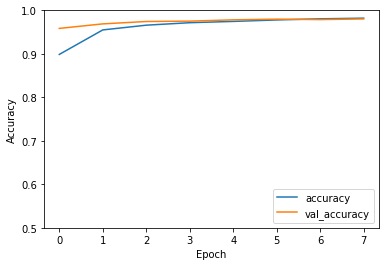

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# num_parallel_calls - pozwala na szybsze wykonanie map poprzez równoległe mapowanie wielu elementów
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
# shuffle bierze buffer_size który ustawiamy na wielkość zbioru żeby na pewno było dobrze pomieszane
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# dzielenie na części dla każdej generacji
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=8,
    validation_data=ds_test,
)

accuracy_graph(history)
# model.summary()

Wykres pokazuje zmianę dokładności na przestrzeni epok. Jak widać nawet po mniej niż 10 iteracjach przyrosty są znikome. Dlatego jeśli chcemy mieć bardzo dokładny model to niestety musimy poświęcić dużo czasu i zasobów komputera na szkolenie.

Po przeszkoleniu modelu możemy zacząć go używać do klasyfikacji naszych własnych danych.

Wczytujemy numery które sami napisaliśmy i przekształcamy do postaci akceptowanej przez model. Czyli zamieniamy ponownie wartości pixeli na skalę od 0 do 1 i jeśli trzeba to skalujemy do rozmiaru 28 na 28 pixeli.

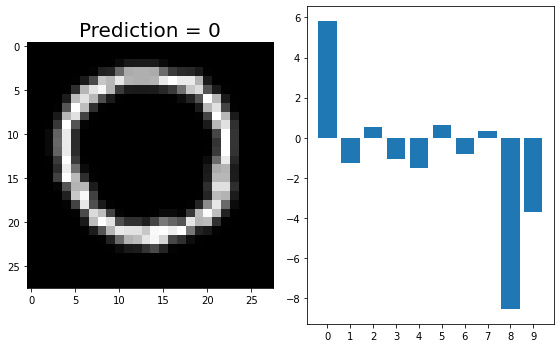

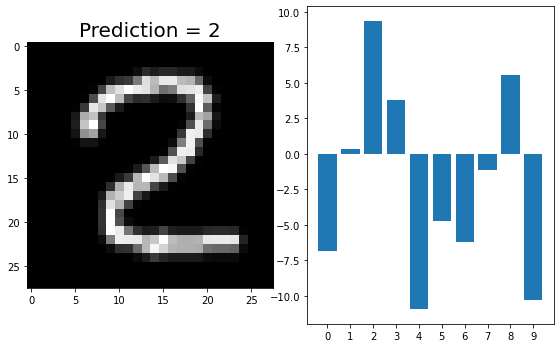

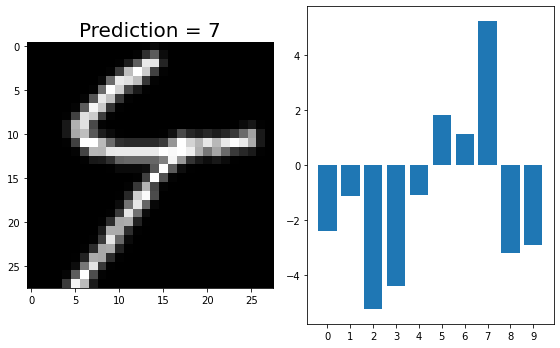

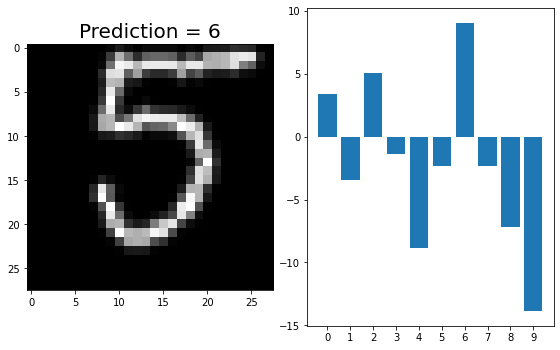

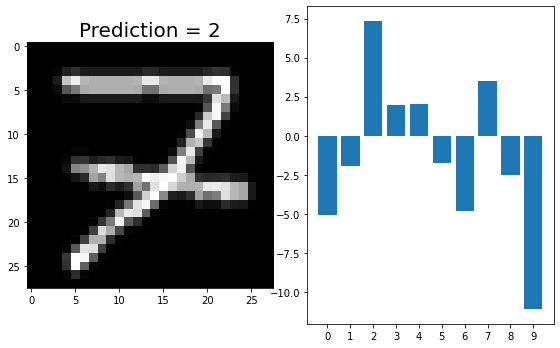

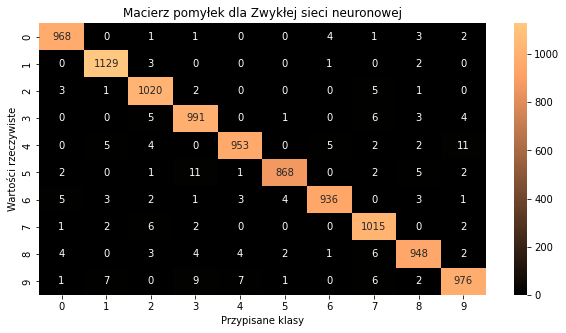

In [9]:
categories = range(0, 10)

our_nums = ["test_0", "test_2", "test_4", "test_5", "test_7"]

predict_nums(our_nums, model)

conf_matrix(model, "Zwykłej sieci neuronowej")

Jak widać model jest w stanie z dużą dokładnością stwierdzić jaki numer napisaliśmy. Ma on jednak problem z siódemką zapisaną z kreską i kategoryzuje ją często jako cztery albo dwa. Problemem też są niezgrabnie napisane liczby, w szczególności 5, 2, 4.

Po prawej stronie od liczby znajduje się wykres pewności czyli w zasadzie wartości ostatniej warstwy sieci. Im jest wyższa  tym większa szansa, że dany numer należy do danej kategorii.

Macierz pomyłek ukazuje nam, że w dobrze obrobionym zbiorze najbardziej mylone są 7 -> 2, 8 -> 3, 5 -> 4 i 9 -> 4.
Jak się nad tym zastanowić to ma to sens ponieważ rzeczywiście 7 i 2 mają podobny kształt a 8 to 3 z dwoma przerwami.

Model działa poprawnie jeżeli mamy dużą ilość epok w szkoleniu. Przy zmniejszaniu zaczyna się on mocno mylić.

#### Wnioski
- sieć neuronowa może w łatwy sposób poradzić sobie z zadaniem kategoryzacji numerów
- żeby model lepiej radził sobie z rozróżnianiem skrajnych przypadków i złego pisma należałoby stworzyć bardziej dokładne warstwy i potworzyć jakieś zależności ograniczenia między neuronami
- dla dobrze przerobionych obrazów (takich jak w MINST) model ma bardzo wysoką dokładność

## Sieć splotowa

Od poprzedniej różni się tym, że stosuje warstwy splotowe, które są specjalnie dostosowane do przyjmowania obrazów jako wejścia. Dużo lepiej radzi sobie z kategoryzowaniem obrazów.

Wejście do warstwy splotowej jest tensorem, w przeciwieństwie do jednowymiarowego wejścia w warstwie gęstej. Taka warstwa reaguje na dane w swoim polu receptywności i podaje dalej wyważone dane.

Warstwa puli służy do zmniejszania wymiarów danych łącząc je ze sobą.

Epoch 1/8
469/469 [==============================] - 18s 38ms/step - loss: 0.2361 - sparse_categorical_accuracy: 0.9269 - val_loss: 0.0620 - val_sparse_categorical_accuracy: 0.9808
Epoch 2/8
469/469 [==============================] - 17s 36ms/step - loss: 0.0607 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.0520 - val_sparse_categorical_accuracy: 0.9815
Epoch 3/8
469/469 [==============================] - 18s 39ms/step - loss: 0.0424 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0336 - val_sparse_categorical_accuracy: 0.9900
Epoch 4/8
469/469 [==============================] - 16s 35ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.0308 - val_sparse_categorical_accuracy: 0.9901
Epoch 5/8
469/469 [==============================] - 19s 40ms/step - loss: 0.0273 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.0264 - val_sparse_categorical_accuracy: 0.9919
Epoch 6/8
469/469 [==============================] - 16s 34ms/step - loss: 0.0218 - sparse_cate

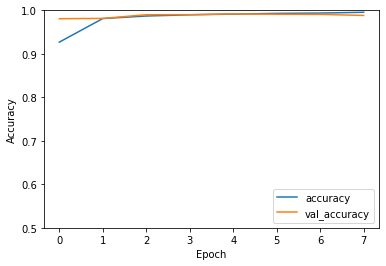

In [4]:
seq_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (5, 5), activation="relu", input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (4, 4), activation="relu"),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

seq_model.compile(
  optimizer=tf.keras.optimizers.Adam(0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = seq_model.fit(
  ds_train,
  epochs=8,
  validation_data=ds_test,
)

accuracy_graph(history)

Ponownie zobaczymy jak sobie radzi z naszymi liczbami.

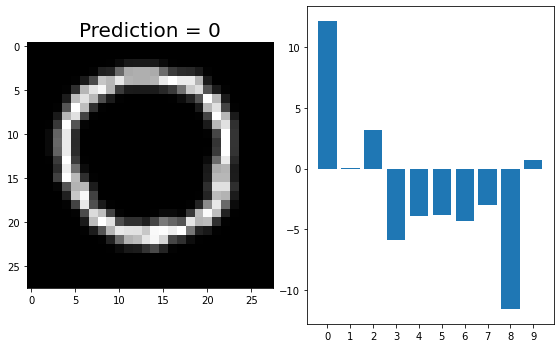

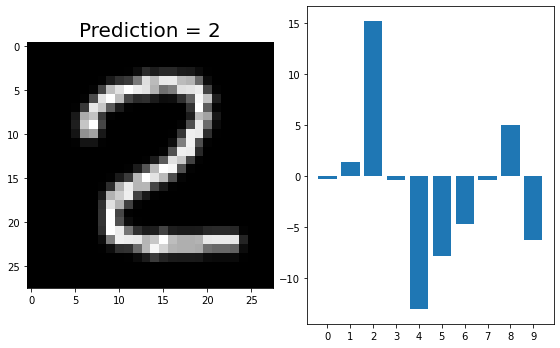

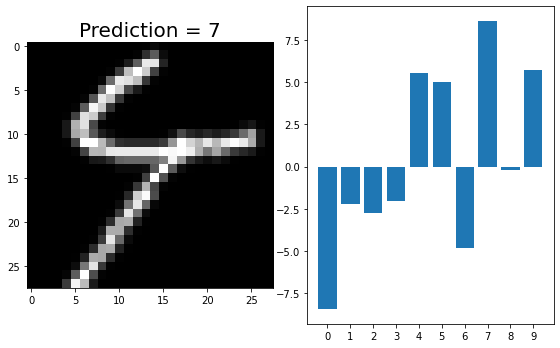

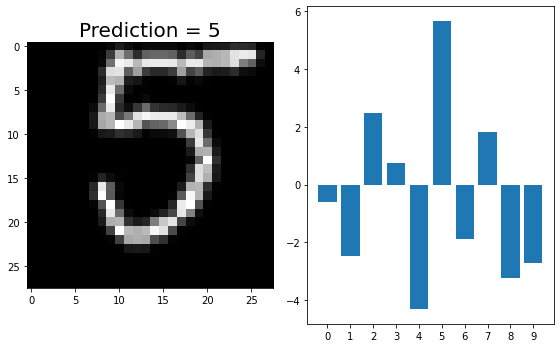

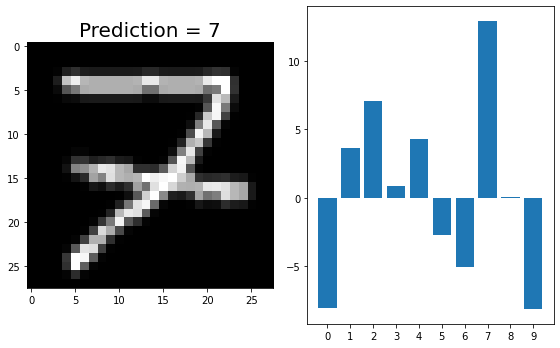

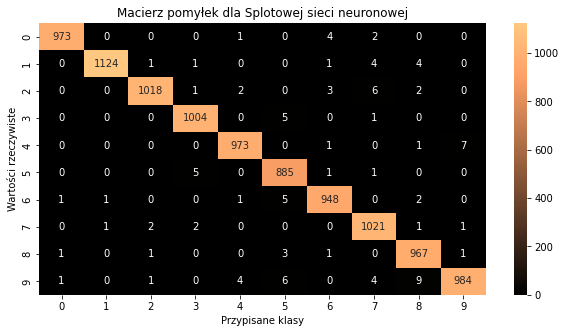

In [5]:
predict_nums(our_nums, seq_model)

conf_matrix(seq_model, "Splotowej sieci neuronowej")

Jak widać na macierzy pomyłek, nie mamy tu już typowych dla poprzedniej sieci błędów.
Zostały jednak zamienienia 2 -> 7, 4 -> 9, 6 -> 4, ale są one jednak dużo rzadsze.

W naszych numerach widać też trochę mniej błędów, ale jest to zależne od każdego szkolenia i zestaw danych jest za mały, żeby móc go uznać za miarodajny.

#### Wnioski
- szkolenie takiej sieci trwa o wiele dłużej
- sieć splotowa jest pewniejsza i trochę lepiej radzi sobie z przypadkami granicznymi
- teoretycznie jej dokładność jest bardzo wysoka, ale jak widać na przykładach nie z bazy MINST nie oznacza to że potrafi rozpoznać nasze obrazy poprawnie
- powodem błędnego kategoryzowania naszych przykładów, może być niedokładna obróbka i brak filtrowania obrazów

### 5. Porównanie rozwiązań i wnioski.

Najlepszym (najdokładnijszym) z klasyfikatorów omawianych na zajęciach okazał się być klasyfikator k-najbliższych sąsiadów (przy k = 3), osiągnąwszy błąd 2.95%. Nawet lepszą skuteczność uzyskał jednak dzięki poddaniu danych wejściowych wstępnemu, dwukrotnemu zmniejszeniu rozdzielczości - błąd wyniósł wtedy 2.42% (dla k = 9). Są to bardzo dobre wyniki, choć mogłyby być lepsze. Problemem jest także czas wykonywania operacji klasyfikacji, który dla dużych danych jest dosyć znaczący (10000 danych wejściowych w około 15sec). Oczywiście redukcja rozmiarów obrazów nieco to przyspieszyła.

Najlepszą siecią jest sieć splotowa. Tworzy ona bardzo niewiele złych kategoryzacji a jej dokładność po 8 epokach w naszej konfiguracji to aż 98,8%. Wyszkolenie jej zajmuje jednak dużo czasu i mocy obliczeniowej. 
Wyniki da się poprawić poprzez zwiększenie ilości epok i optymalizację warstw.
Dla obrazów, które nie przeszły dobrej obróbki jest ona dość niedokładna.
W przypadku mniejszej ilości epok wyniki mogą się znacząco różnić z uczenia na uczenie.
Raz rozpozna poprawnie 7 jako 7 a raz stwierdzi, że to 4.

## Źródła

#### Sieci neuronowe
- https://www.tutorialexample.com/understand-dense-layer-fully-connected-layer-in-neural-networks-deep-learning-tutorial/
- https://www.tensorflow.org/datasets/keras_example
- https://www.theprofessionalprogrammer.com/2018/11/neural-network-dense-layers.html
- https://iq.opengenus.org/dense-layer-in-tensorflow/
- https://machinelearningjourney.com/index.php/2021/01/09/adam-optimizer/
- https://iq.opengenus.org/relu-activation/
- https://pl.abcdef.wiki/wiki/Convolutional_neural_network

### Reszta
- https://en.wikipedia.org/wiki/MNIST_database
- https://www.tensorflow.org/datasets/catalog/mnist
- https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d